In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
from datetime import datetime

# ✅ Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Change to your project directory
%cd /content/drive/MyDrive/RemoteSensing-Lora-InstructBlip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RemoteSensing-Lora-InstructBlip


In [2]:
# Step 2: Install dependencies from requirements.txt
# !pip install -r requirements.txt

In [3]:
#!/usr/bin/env python3
"""
Clean LoRA Training Script for InstructBLIP on RSICap
Supports YAML configuration files for flexible training
"""

import sys
import os
import json
import yaml
from datetime import datetime
# sys.path.insert(0, os.path.join(os.path.dirname(__file__), 'module'))
sys.path.insert(0, '/content/drive/MyDrive/RemoteSensing-Lora-InstructBlip/module')

from config import Config
from data.rsicap_dataset import load_rsicap_data, RSICapDataset, collate_fn
from torch.utils.data import DataLoader
from models.lora_model import LoRAInstructBLIP
from training.trainer import LoRATrainer
import torch
import gc

# 强制清理
torch.cuda.empty_cache()
gc.collect()

# # 中国镜像支持
# os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# ============================================================================
# CONFIGURATION FILES TO RUN
# ============================================================================
# Define which config files to run (can be single or multiple)
CONFIG_FILES = [
    # "configs/baseline_lora_instructblip.yml",
    # "configs/high_lr_experiment.yml",  # Add more configs here
    # "configs/large_batch_experiment.yml",
    # "configs/grid_search_v4_extreme_rank.yml",
    # "configs/grid_search_v6_Moderate_Rank_Wider_Batch.yml",
    # "configs/grid_search_v7_middle_rank_8epochs.yml",
    "configs/grid_search_v8_middle_rank_15epochs_slower_lr.yml",
]

# ============================================================================
# YAML CONFIG LOADER
# ============================================================================
def load_yaml_config(config_path):
    """Load configuration from YAML file"""
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found: {config_path}")

    with open(config_path, 'r', encoding='utf-8') as f:
        yaml_config = yaml.safe_load(f)

    print(f"📋 Loaded config: {yaml_config.get('name', 'unnamed')}")
    if 'description' in yaml_config:
        print(f"📝 Description: {yaml_config['description']}")

    return yaml_config

def train_single_config(config_path):
    """Train with a single YAML configuration"""

    # Load YAML configuration
    yaml_config = load_yaml_config(config_path)

    print("="*60)
    print("🚀 LoRA Training - InstructBLIP on RSICap")
    print(f"📋 Config: {yaml_config.get('name', 'unnamed')}")
    print("="*60)

    # Create config object
    config = Config()

    # Apply YAML config (skip metadata fields)
    metadata_fields = {'name', 'description'}
    for key, value in yaml_config.items():
        if key not in metadata_fields:
            setattr(config, key, value)

    # Create output directory using config name
    config_name = yaml_config.get('name', 'unnamed_config')
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    config.save_dir = f"checkpoints/{config_name}_{timestamp}"
    os.makedirs(config.save_dir, exist_ok=True)

    # 数据路径已在 config.py 中正确设置

    # 显示配置
    print(f"📋 Training Configuration:")
    print(f"  LoRA rank (r): {config.lora_r}")
    print(f"  LoRA alpha: {config.lora_alpha}")
    print(f"  Learning rate: {config.learning_rate}")
    print(f"  Epochs: {config.num_epochs}")
    print(f"  Batch size: {config.batch_size}")
    print(f"  Max samples: {config.max_samples}")
    print(f"  Save dir: {config.save_dir}")
    print()

    # 加载组件
    print("Loading LoRA model...")
    model = LoRAInstructBLIP(config)
    print("✅ Model loaded successfully!")

    print("Loading dataset...")
    train_loader, val_loader, processor = load_rsicap_data(config)
    print("✅ Dataset loaded successfully!")

    # 限制数据量
    if config.max_samples:
        print(f"🔢 Limiting training to {config.max_samples} samples")
        limited_train_data = list(train_loader.dataset.data)[:config.max_samples]
        limited_train_dataset = RSICapDataset(
            limited_train_data,
            train_loader.dataset.images_dir,
            train_loader.dataset.processor,
            'train'
        )
        train_loader = DataLoader(
            limited_train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
            collate_fn=collate_fn
        )
        print(f"✅ Limited to {len(train_loader)} batches per epoch")

    # 创建训练器
    print("Creating trainer...")
    trainer = LoRATrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config
    )
    print("✅ Trainer created successfully!")

    # 验证 LoRA 配置
    model.verify_lora_training()

    # 开始训练
    print("\n🚀 Starting LoRA training...")
    print("="*60)

    latest_checkpoint_path = None

    for epoch in range(config.num_epochs):
        print(f"\n--- Epoch {epoch + 1}/{config.num_epochs} ---")

        # 训练
        train_loss, epoch_time = trainer.train_epoch(epoch)

        # 验证
        val_loss = trainer.validate(epoch)

        print(f"Epoch {epoch + 1}: Train={train_loss:.4f}, Val={val_loss:.4f}, Time={epoch_time:.1f}s")

        # 保存每个epoch的历史记录
        epoch_summary = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "epoch_time": epoch_time,
            "learning_rate": trainer.optimizer.param_groups[0]['lr'] if hasattr(trainer, 'optimizer') else None,
            "timestamp": datetime.now().isoformat()
        }

        # 保存单个epoch总结
        epoch_file = os.path.join(config.save_dir, f"epoch_{epoch+1}_summary.json")
        with open(epoch_file, 'w', encoding='utf-8') as f:
            json.dump(epoch_summary, f, ensure_ascii=False, indent=2)

        # 保存累积历史
        history_file = os.path.join(config.save_dir, "training_history.json")
        if os.path.exists(history_file):
            with open(history_file, 'r', encoding='utf-8') as f:
                history = json.load(f)
        else:
            history = {"epochs": []}

        history["epochs"].append(epoch_summary)
        history["config"] = yaml_config
        history["last_updated"] = datetime.now().isoformat()

        with open(history_file, 'w', encoding='utf-8') as f:
            json.dump(history, f, ensure_ascii=False, indent=2)

        print(f"📊 Epoch {epoch + 1} history saved")

        # 保存检查点
        if (epoch + 1) % 2 == 0 or epoch == config.num_epochs - 1:
            latest_checkpoint_path = os.path.join(config.save_dir, f"checkpoint_epoch_{epoch+1}.pth")
            trainer.save_checkpoint(latest_checkpoint_path, epoch, train_loss, val_loss)
            print(f"💾 Checkpoint saved: {latest_checkpoint_path}")

    # 保存训练总结和生成可视化
    print("\n" + "="*60)
    print("🎉 Training Completed!")
    print("="*60)

    # 调用trainer的详细保存功能（包含可视化）
    if hasattr(trainer, 'save_training_summary'):
        detailed_summary_path = trainer.save_training_summary()
        print(f"📊 Detailed training summary with plots saved: {detailed_summary_path}")
    else:
        # 如果trainer没有这个方法，调用plot_losses
        if hasattr(trainer, 'plot_losses'):
            trainer.plot_losses()
            print(f"📈 Training curves saved to: {config.save_dir}/training_curves.png")

    # 保存基本总结
    summary = {
        "training_completed": datetime.now().isoformat(),
        "config": yaml_config,
        "final_losses": {
            "train_loss": trainer.train_losses[-1] if trainer.train_losses else None,
            "val_loss": trainer.val_losses[-1] if trainer.val_losses else None
        },
        "best_val_loss": min(trainer.val_losses) if trainer.val_losses else None,
        "total_epochs": len(trainer.train_losses),
        "total_training_time": sum(trainer.epoch_times) if hasattr(trainer, 'epoch_times') else None,
        "checkpoints_dir": config.save_dir
    }

    summary_path = os.path.join(config.save_dir, "training_summary.json")
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    print(f"📄 Basic training summary saved: {summary_path}")
    print(f"💾 Latest checkpoint: {latest_checkpoint_path}")
    print(f"📁 All files saved to: {config.save_dir}")
    print("\n✅ All done!")
    return latest_checkpoint_path

def main():
    """Main function to run training with multiple configurations"""

    print("🚀 Starting LoRA Training Pipeline")
    print(f"📁 Found {len(CONFIG_FILES)} configuration(s) to run")
    print("="*60)

    results = []

    for i, config_path in enumerate(CONFIG_FILES, 1):
        print(f"\n🔄 Running configuration {i}/{len(CONFIG_FILES)}: {config_path}")

        try:
            checkpoint_path = train_single_config(config_path)
            results.append({
                "config_path": config_path,
                "status": "success",
                "checkpoint": checkpoint_path
            })
            print(f"✅ Configuration {i} completed successfully!")

        except Exception as e:
            print(f"❌ Configuration {i} failed: {e}")
            results.append({
                "config_path": config_path,
                "status": "failed",
                "error": str(e)
            })

    # Print final summary
    print("\n" + "="*60)
    print("🎉 Training Pipeline Completed!")
    print("="*60)

    successful = [r for r in results if r["status"] == "success"]
    failed = [r for r in results if r["status"] == "failed"]

    print(f"✅ Successful: {len(successful)}")
    print(f"❌ Failed: {len(failed)}")

    if successful:
        print("\n📊 Successful Runs:")
        for result in successful:
            config_name = os.path.basename(result["config_path"])
            print(f"  - {config_name} → {result['checkpoint']}")

    if failed:
        print("\n💥 Failed Runs:")
        for result in failed:
            config_name = os.path.basename(result["config_path"])
            print(f"  - {config_name}: {result['error']}")

if __name__ == "__main__":
    main()


🚀 Starting LoRA Training Pipeline
📁 Found 1 configuration(s) to run

🔄 Running configuration 1/1: configs/grid_search_v8_middle_rank_15epochs_slower_lr.yml
📋 Loaded config: grid_search_v8_middle_rank_15epochs
📝 Description: Grid search configuration for higher LoRA and wider batch
🚀 LoRA Training - InstructBLIP on RSICap
📋 Config: grid_search_v8_middle_rank_15epochs
📋 Training Configuration:
  LoRA rank (r): 24
  LoRA alpha: 48
  Learning rate: 0.0002
  Epochs: 15
  Batch size: 15
  Max samples: 2068
  Save dir: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640

Loading LoRA model...
Loading base model: Salesforce/instructblip-flan-t5-xl


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Applying LoRA to Q-Former only...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


trainable params: 7,262,208 || all params: 4,030,231,296 || trainable%: 0.1802
✅ Model loaded successfully!
Loading dataset...
Loading RSICap data from data/rsgpt_dataset/RSICap/captions.json
Loaded 2585 samples
Split: 2068 train, 517 validation
✅ Dataset loaded successfully!
🔢 Limiting training to 2068 samples
✅ Limited to 138 batches per epoch
Creating trainer...
✅ Trainer created successfully!

LoRA Training Verification
Total parameters: 4,030,231,296
Trainable parameters: 7,262,208
Trainable percentage: 0.1802%
LoRA parameters found: 240

LoRA Parameters Details:
  base_model.model.qformer.encoder.layer.0.attention.attention.query.lora_A.default.weight: torch.Size([24, 768]), mean=-0.000057, std=0.020764
  base_model.model.qformer.encoder.layer.0.attention.attention.query.lora_B.default.weight: torch.Size([768, 24]), mean=0.000000, std=0.000000
  base_model.model.qformer.encoder.layer.0.attention.attention.key.lora_A.default.weight: torch.Size([24, 768]), mean=0.000170, std=0.0208

Epoch 1/15:   0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Epoch 1/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.7961, Avg=1.9294, LR=1.8e-04]


✅ Epoch 1 completed in 294.54s
📊 Average training loss: 1.9294
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.5808
🔢 Processed 35/35 valid validation batches
Epoch 1: Train=1.9294, Val=1.5808, Time=294.5s
📊 Epoch 1 history saved

--- Epoch 2/15 ---


Epoch 2/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.5193, Avg=1.6590, LR=2.0e-04]


✅ Epoch 2 completed in 294.61s
📊 Average training loss: 1.6590
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.5165
🔢 Processed 35/35 valid validation batches
Epoch 2: Train=1.6590, Val=1.5165, Time=294.6s
📊 Epoch 2 history saved
Model saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_2.pth
Checkpoint saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_2.pth
💾 Checkpoint saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_2.pth

--- Epoch 3/15 ---


Epoch 3/15: 100%|██████████| 138/138 [04:54<00:00,  2.14s/it, Loss=1.5849, Avg=1.6117, LR=2.0e-04]


✅ Epoch 3 completed in 294.70s
📊 Average training loss: 1.6117
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4693
🔢 Processed 35/35 valid validation batches
Epoch 3: Train=1.6117, Val=1.4693, Time=294.7s
📊 Epoch 3 history saved

--- Epoch 4/15 ---


Epoch 4/15: 100%|██████████| 138/138 [04:54<00:00,  2.14s/it, Loss=1.4912, Avg=1.5827, LR=2.0e-04]


✅ Epoch 4 completed in 294.65s
📊 Average training loss: 1.5827
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4695
🔢 Processed 35/35 valid validation batches
Epoch 4: Train=1.5827, Val=1.4695, Time=294.6s
📊 Epoch 4 history saved
Model saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_4.pth
Checkpoint saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_4.pth
💾 Checkpoint saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_4.pth

--- Epoch 5/15 ---


Epoch 5/15: 100%|██████████| 138/138 [04:54<00:00,  2.14s/it, Loss=1.6128, Avg=1.5670, LR=2.0e-04]


✅ Epoch 5 completed in 294.83s
📊 Average training loss: 1.5670
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4432
🔢 Processed 35/35 valid validation batches
Epoch 5: Train=1.5670, Val=1.4432, Time=294.8s
📊 Epoch 5 history saved

--- Epoch 6/15 ---


Epoch 6/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.6319, Avg=1.5516, LR=2.0e-04]


✅ Epoch 6 completed in 294.42s
📊 Average training loss: 1.5516
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4473
🔢 Processed 35/35 valid validation batches
Epoch 6: Train=1.5516, Val=1.4473, Time=294.4s
📊 Epoch 6 history saved
Model saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_6.pth
Checkpoint saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_6.pth
💾 Checkpoint saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_6.pth

--- Epoch 7/15 ---


Epoch 7/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.5540, Avg=1.5426, LR=2.0e-04]


✅ Epoch 7 completed in 294.15s
📊 Average training loss: 1.5426
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4281
🔢 Processed 35/35 valid validation batches
Epoch 7: Train=1.5426, Val=1.4281, Time=294.2s
📊 Epoch 7 history saved

--- Epoch 8/15 ---


Epoch 8/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.4871, Avg=1.5262, LR=2.0e-04]


✅ Epoch 8 completed in 294.08s
📊 Average training loss: 1.5262
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4275
🔢 Processed 35/35 valid validation batches
Epoch 8: Train=1.5262, Val=1.4275, Time=294.1s
📊 Epoch 8 history saved
Model saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_8.pth
Checkpoint saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_8.pth
💾 Checkpoint saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_8.pth

--- Epoch 9/15 ---


Epoch 9/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.4801, Avg=1.5181, LR=2.0e-04]


✅ Epoch 9 completed in 294.39s
📊 Average training loss: 1.5181
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4136
🔢 Processed 35/35 valid validation batches
Epoch 9: Train=1.5181, Val=1.4136, Time=294.4s
📊 Epoch 9 history saved

--- Epoch 10/15 ---


Epoch 10/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.6284, Avg=1.5082, LR=2.0e-04]


✅ Epoch 10 completed in 294.29s
📊 Average training loss: 1.5082
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4134
🔢 Processed 35/35 valid validation batches
Epoch 10: Train=1.5082, Val=1.4134, Time=294.3s
📊 Epoch 10 history saved
Model saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_10.pth
Checkpoint saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_10.pth
💾 Checkpoint saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_10.pth

--- Epoch 11/15 ---


Epoch 11/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.3980, Avg=1.4996, LR=2.0e-04]


✅ Epoch 11 completed in 294.39s
📊 Average training loss: 1.4996
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4061
🔢 Processed 35/35 valid validation batches
Epoch 11: Train=1.4996, Val=1.4061, Time=294.4s
📊 Epoch 11 history saved

--- Epoch 12/15 ---


Epoch 12/15: 100%|██████████| 138/138 [04:53<00:00,  2.13s/it, Loss=1.5437, Avg=1.4873, LR=2.0e-04]


✅ Epoch 12 completed in 293.74s
📊 Average training loss: 1.4873
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4104
🔢 Processed 35/35 valid validation batches
Epoch 12: Train=1.4873, Val=1.4104, Time=293.7s
📊 Epoch 12 history saved
Model saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_12.pth
Checkpoint saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_12.pth
💾 Checkpoint saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_12.pth

--- Epoch 13/15 ---


Epoch 13/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.4466, Avg=1.4810, LR=2.0e-04]


✅ Epoch 13 completed in 294.02s
📊 Average training loss: 1.4810
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.3998
🔢 Processed 35/35 valid validation batches
Epoch 13: Train=1.4810, Val=1.3998, Time=294.0s
📊 Epoch 13 history saved

--- Epoch 14/15 ---


Epoch 14/15: 100%|██████████| 138/138 [04:54<00:00,  2.13s/it, Loss=1.4110, Avg=1.4716, LR=2.0e-04]


✅ Epoch 14 completed in 294.42s
📊 Average training loss: 1.4716
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.4073
🔢 Processed 35/35 valid validation batches
Epoch 14: Train=1.4716, Val=1.4073, Time=294.4s
📊 Epoch 14 history saved
Model saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_14.pth
Checkpoint saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_14.pth
💾 Checkpoint saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_14.pth

--- Epoch 15/15 ---


Epoch 15/15: 100%|██████████| 138/138 [04:53<00:00,  2.12s/it, Loss=1.5639, Avg=1.4641, LR=2.0e-04]


✅ Epoch 15 completed in 293.21s
📊 Average training loss: 1.4641
🔢 Processed 138/138 valid batches


📈 Validation loss: 1.3987
🔢 Processed 35/35 valid validation batches
Epoch 15: Train=1.4641, Val=1.3987, Time=293.2s
📊 Epoch 15 history saved
Model saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_15.pth
Checkpoint saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_15.pth
💾 Checkpoint saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/checkpoint_epoch_15.pth

🎉 Training Completed!
📊 Detailed training summary saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/training_summary_detailed.json
📈 Training curves saved to checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/training_curves.png
📊 Detailed training summary with plots saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/training_summary_detailed.json
📄 Basic training summary saved: checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/training_summary.json
💾 Latest check

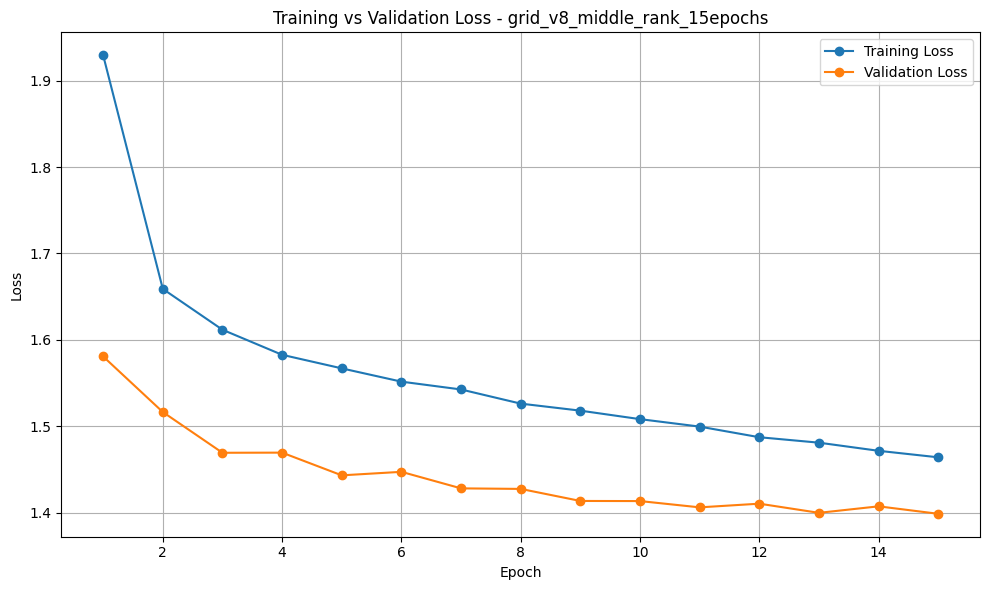

<Figure size 640x480 with 0 Axes>

✅ Plot saved to: /content/drive/MyDrive/RemoteSensing-Lora-InstructBlip/loss_plot_v8_middle_rank.png


In [6]:
import json
import matplotlib.pyplot as plt



import json
import matplotlib.pyplot as plt
import os

# Set path to your training summary file
# Replace this with your full path if running in Colab
summary_path = "/content/drive/MyDrive/RemoteSensing-Lora-InstructBlip/checkpoints/grid_search_v8_middle_rank_15epochs_20250725_002640/training_summary.json"

# Check file exists
if not os.path.exists(summary_path):
    raise FileNotFoundError(f"{summary_path} not found")

# Load JSON summary
with open(summary_path, "r", encoding="utf-8") as f:
    summary = json.load(f)

# Load epoch-by-epoch history (if not in this file, load from training_history.json instead)
history_path = os.path.join(summary["checkpoints_dir"], "training_history.json")
if not os.path.exists(history_path):
    raise FileNotFoundError(f"{history_path} not found")

with open(history_path, "r", encoding="utf-8") as f:
    history = json.load(f)

# Extract losses
epochs = [e["epoch"] for e in history["epochs"]]
train_losses = [e["train_loss"] for e in history["epochs"]]
val_losses = [e["val_loss"] for e in history["epochs"]]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - grid_v8_middle_rank_15epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# # ✅ Save plot to Google Drive
# save_path = "/content/drive/MyDrive/RemoteSensing-Lora-InstructBlip/loss_plot_v8_middle_rank.png"
# plt.savefig(save_path)
# plt.show()

# print(f"✅ Plot saved to: {save_path}")
